Copyright (C) rflylab from School of Automation Science and Electrical Engineering, Beihang University.

All Rights Reserved.

This example shows how to assess the doc of controllability of the propulsion system of the multicopters.
The lumped disturbance is esitimated by kalman filter and then the DOC based on the Available Control Authority Index (ACAI) is computed.

In [1]:
# import necessary packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

# the OpenHA package
from OpenHA.assessment.attribute import degree_of_controllablity as DOC

In [2]:
# load the data from the local csv file
# the names of the columns are
# timestamp,euler_re_roll,euler_re_pitch,euler_re_yaw,omega_re_p,omega_re_q,omega_re_r,sigma_re,,,,z_re,vz_re,dot_euler_re,,,eta_1,,,eta_4,doc

# they are available on https://github.com/rfly-openha/documents/tree/main/2_tutorial/examples

data = pd.read_csv('log_7_2022-5-12-16-22-12_lossfactor.csv', header=0)

In [3]:
# data from the csv file
# timestamp
timestamp = data.values[:, 0] / 1e6
# euler angles
euler = data.values[:, 1:4].T
# angular velocity
omega = data.values[:, 4:7].T
# throttle
sigma = data.values[:, 7:11].T
# height and velocity
z = data.values[:, 11]
vz = data.values[:, 12]
# euler angular acceleration
dot_euler = data.values[:, 13:16].T

In [4]:
# arguments of the phycial parameters
# number of propeller
n_p = 4
# mass and moment of inertia
ma = 1.4
g = 9.8
Jx = 0.0211
Jy = 0.0219
Jz = 0.0366
J = np.diag([-1 / ma, 1 / Jx, 1 / Jy, 1 / Jz])
# calculate the force by throttle
Cb = 1148 / 12.6
Ub = 12.6
omega_b = -141.4
ct = 1.105e-05
f = ct * (Cb * Ub * sigma + omega_b) ** 2
# maximun value of the force of each propeller
fmax = ct * (Cb * Ub * 1 + omega_b) ** 2

In [5]:
# control allocation matrix
d = 0.225
cm_ct = 0.0161
# pay attention to the number and rotate direction of each propeller
Bf = DOC.control_allocation(
    n_p,
    d,
    cm_ct,
    init_angle=np.array([45, 225, 315, 135]) * np.pi / 180,
    drct=[1, 1, -1, -1],
)
Bf = np.matrix(Bf)
# maximun value of the ACAI
acai_max = DOC.acai(Bf, fmax, 0, np.array([[ma * g, 0, 0, 0]]).T)


In [6]:
# sample time
ts = 0.05

# matrix of the state equation
A = np.zeros((8, 8))
A[0:4, 4:8] = np.eye(4)
B = np.concatenate((np.zeros((4, 4)), J), axis=0)
A = np.matrix(A)
B = np.matrix(B)

# discretization
Ak = np.eye(8) + ts * A
Bk = (np.eye(8) * ts + A * ts**2) * B

# extend matrix of the state equation
Phi = np.concatenate(
    (
        np.concatenate((Ak, -Bk), axis=1),
        np.concatenate((np.zeros((4, 8)), np.eye(4)), axis=1),
    ),
    axis=0,
)
Phi = np.matrix(Phi)
Psi = np.concatenate((Bk, np.zeros((4, 4))), axis=0)
Psi = np.matrix(Psi)
H = np.concatenate((np.eye(8), np.zeros((8, 4))), axis=1)
H = np.matrix(H)
# covariance matrix of noise
Q = np.diag(
    np.concatenate(
        (
            np.ones(
                8,
            )
            * 0.01**2,
            np.array([0.1**2]),
            np.ones(
                3,
            )
            * 0.001**2,
        )
    )
)
R = np.eye(8) * 1**2

# Initial value of state and Covariance matrix
X = np.zeros((12, 1))
X[2] = ma * g
P = np.eye(12) * 0.1

# used to save the final result
length = timestamp.shape[0]
doc = np.zeros((length,))

distb = np.zeros((4, length))


In [7]:
# algorithm of the kalman filter
for i in range(length):
    X_pre = Phi * X + Psi * Bf * f[:, (i,)]
    P_pre = Phi * P * Phi.T + Q
    K = P_pre * H.T * sp.linalg.inv(H * P_pre * H.T + R)

    Z_k = np.concatenate(
        (np.array([[z[i]]]), euler[:, (i,)], np.array([[vz[i]]]), omega[:, (i,)]),
        axis=0,
    )
    X = X_pre + K * (Z_k - H * X_pre)
    P = (np.eye(12) - K * H) * P_pre

    # save the esitimate result
    distb[:, (i,)] = X[8:12, 0]
    doc[i] = DOC.acai(Bf, fmax, 0, X[8:12, 0]) / acai_max


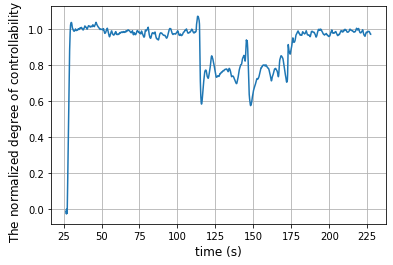

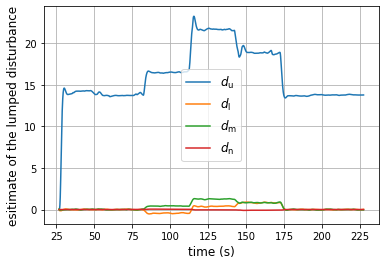

In [8]:
# plot
fig, ax = plt.subplots()
ax.set_xlabel('time (s)', fontsize=12)
ax.set_ylabel(r'The normalized degree of controllability $\rho$', fontsize=12)
ax.plot(timestamp, doc)
ax.grid()

fig, ax = plt.subplots()
ax.set_xlabel('time (s)', fontsize=12)
ax.set_ylabel('esitimate of the lumped disturbance', fontsize=12)
ax.plot(timestamp, distb.T)
ax.grid()
ax.legend(
    [
        r'$d_\mathrm{u}$',
        r'$d_\mathrm{l}$',
        r'$d_\mathrm{m}$',
        r'$d_\mathrm{n}$',
    ],
    fontsize=12,
)
plt.show()
